In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
#zaczytanie danych
train = pd.read_csv(r"C:\Users\pc\Downloads\data_green\train_green.csv")
test = pd.read_csv(r"C:\Users\pc\Downloads\data_green\test_green.csv")

In [24]:
#w zadaniu 3 X to zmienne predykcyjne z modelu
X_train = train.drop(['PRED_BINNED', 'SEG_1', 'SEG_2', 'SEG_3'], axis = 1)
pred_train = train['PRED']
y_train = train['TARGET']
X_test = test.drop(['PRED_BINNED', 'SEG_1', 'SEG_2', 'SEG_3'], axis = 1)
pred_test = test['PRED']
y_test= test['TARGET']
#iloraz szans
train_odds = (pred_train)/(1-pred_train)

In [5]:
#ignorowanie warningów dla notebooka (df_approx['score_diff'] = np.abs(df_approx['PRED']-X_train[i]) produkuje warning)
import warnings
warnings.filterwarnings('ignore')

## MAHALANOBIS DISTANCE

In [67]:
#źródło: https://www.geeksforgeeks.org/how-to-calculate-mahalanobis-distance-in-python/
def calculateMahalanobis(y=None, data=None, cov=None): 
  
    y_mu = y - np.mean(data) 
    if not cov: 
        cov = np.cov(data.values.T) 
    inv_covmat = np.linalg.inv(cov) 
    left = np.dot(y_mu, inv_covmat) 
    mahal = np.dot(left, y_mu.T) 
    return mahal
# .diagonal() 

In [20]:
X_train.notna().sum()

FEAT_1     281235
FEAT_2     268139
FEAT_3     291787
FEAT_4     281235
FEAT_5     198786
FEAT_6      53732
FEAT_7     255008
FEAT_8     281235
FEAT_9     281235
FEAT_10    268139
FEAT_11    198786
dtype: int64

In [27]:
#dla uproszeczenia do odległości mahalanobisa pozbędziemy się obserwacji z brakami danych
df_mahal_train = X_train.dropna()
pred_mahal_train = df_mahal_train['PRED']
train_odds_mahal = (pred_mahal_train)/(1-pred_mahal_train)
#df_mahal_train = df_mahal_train.drop(['PRED'], axis = 1)
df_mahal_test = X_test.dropna()
pred_mahal_test = df_mahal_test['PRED']
#df_mahal_test = df_mahal_test.drop(['PRED'], axis = 1)

In [159]:
%%time
#przybliżamy prawdopodobieństwo wystąpienia klasy 1 (to będzie nasz y)
#liczba obserwacji służąca do przybliżenia
m = 1000
#w celu zmniejszenia długości obliczeń wybierzemy losowo k obserwacji do przybliżenia rozkładu scorów
n = len(df_mahal_train)
#conformity scores dla ilorazu szans
conformity_scores = []
#odległość mahalanobisa
mahalanobis_distances = []
indexes = df_mahal_train.index
for i in range(n):
    df_approx = df_mahal_train[['PRED', 'TARGET']]
    df_approx['score_diff'] = np.abs(df_approx['PRED']-df_approx['PRED'][indexes[i]])
    a = df_approx.nsmallest(m, 'score_diff')
    indexes_temp = np.array(a.index)
    mean_target = np.mean(a['TARGET'])
    mean_odds = mean_target/(1-mean_target)
    conformity_scores.append(np.abs(train_odds_mahal[indexes[i]]-mean_odds))
    
    a = df_mahal_train.drop(['PRED', 'TARGET'], axis = 1)
    a = a.loc[indexes_temp,:]
    #na zerowym miejscu zawsze będzie rozpatrywana aktualnie obserwacja
    mahalanobis_distances.append(calculateMahalanobis(y = a.iloc[0], data = a))

Wall time: 4min 42s


In [160]:
%%time
#przybliżamy prawdopodobieństwo wystąpienia klasy 1 (to będzie nasz y)
#liczba obserwacji służąca do przybliżenia
m = 1000
#w celu zmniejszenia długości obliczeń wybierzemy losowo k obserwacji do przybliżenia rozkładu scorów
n_test = len(df_mahal_test)
#df_approx = df_mahal_train.drop(['PRED', 'TARGET'], axis = 1)
#df_approx_test = df_mahal_test.drop(['PRED', 'TARGET'], axis = 1)
indexes_2 = df_mahal_test.index
mahalanobis_test = []
b = df_mahal_test.drop(['PRED', 'TARGET'], axis = 1)
for i in range(n_test):
    df_approx = df_mahal_train[['PRED', 'TARGET']]
    df_approx['score_diff'] = np.abs(df_approx['PRED']-df_mahal_test['PRED'][indexes_2[i]])
    a = df_approx.nsmallest(m, 'score_diff')
    indexes_temp = np.array(a.index)
    a = df_mahal_train.drop(['PRED', 'TARGET'], axis = 1)
    a = a.loc[indexes_temp,:]
    mahalanobis_test.append(calculateMahalanobis(y = b.iloc[i], data = a))

Wall time: 18 s


In [161]:
%%time
#jaki jest kwantyl nowych elementów
mahalanobis_rank = []
for i in range(n_test):
    mahalanobis_temp = mahalanobis_distances.copy()
    mahalanobis_temp.append(mahalanobis_test[i])
    mahalanobis_rank.append(scipy.stats.rankdata(mahalanobis_temp)[n]/n)

Wall time: 14.4 s


In [173]:
#conformity scores dla zbioru kalibracyjnego
#conformity_scores = np.maximum(X_train-y_train, y_train-X_train)
#zadany poziom alpha
alpha = 0.01
#liczność próby
#n = len(X_train)
#kwantyl scorów
qhat = np.quantile(conformity_scores, np.ceil((n+1)*(1-alpha))/n)
#regresja dla zbioru testowego
#przedział dla każdego punktu testowego
test_odds = (pred_test[indexes_2])/(1-pred_test[indexes_2])
output_mahalanobis_lower = []
output_mahalanobis_upper = []
for i in range(n_test):
    output_mahalanobis_lower.append(test_odds[indexes_2[i]]-qhat*mahalanobis_rank[i])
    output_mahalanobis_upper.append(test_odds[indexes_2[i]]+qhat*mahalanobis_rank[i])

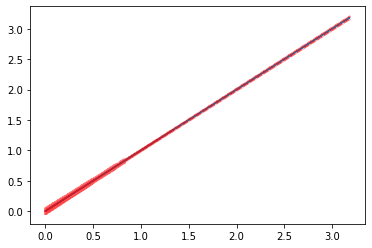

In [186]:
plt.plot(test_odds,test_odds, label = 'Prediction')
plt.fill_between(test_odds, output_mahalanobis_lower, output_mahalanobis_upper, color='r', alpha=.25, label = f'Prediction interval {np.round(1-alpha,2)} level')
plt.plot(test_odds,output_mahalanobis_lower, label = 'Upper bound prediction', color = 'r', linestyle = '--', alpha = 0.5)
plt.plot(test_odds,output_mahalanobis_upper, label = 'Lower bound prediction', color = 'r', linestyle = '--', alpha = 0.5)
plt.show()

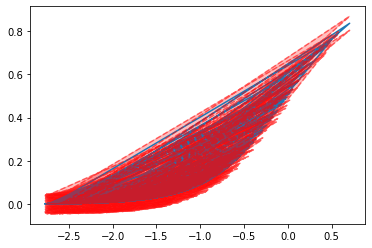

In [191]:
#wykres przedziałów ze skalą logitową
def logit_hist(x):
    return np.log10(x/(1-x))
plt.plot(logit_hist(test_odds),test_odds, label = 'Prediction')
plt.fill_between(logit_hist(test_odds), output_mahalanobis_lower, output_mahalanobis_upper, color='r', alpha=.25, label = f'Prediction interval {np.round(1-alpha,2)} level')
plt.plot(logit_hist(test_odds),output_mahalanobis_lower, label = 'Upper bound prediction', color = 'r', linestyle = '--', alpha = 0.5)
plt.plot(logit_hist(test_odds),output_mahalanobis_upper, label = 'Lower bound prediction', color = 'r', linestyle = '--', alpha = 0.5)
plt.show()

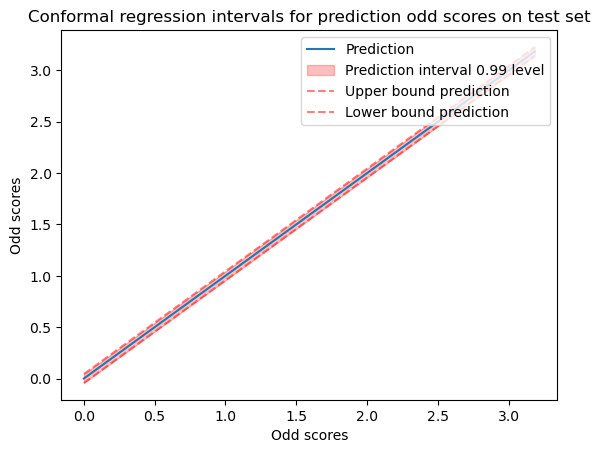

In [65]:
#wykres przedziałów ze skalą liniową
plt.plot(x_odds,x_odds, label = 'Prediction')
plt.fill_between(x_odds, output[0,:], output[1,:], color='r', alpha=.25, label = f'Prediction interval {np.round(1-alpha,2)} level')
plt.plot(x_odds,output[0,:], label = 'Upper bound prediction', color = 'r', linestyle = '--', alpha = 0.5)
plt.plot(x_odds,output[1,:], label = 'Lower bound prediction', color = 'r', linestyle = '--', alpha = 0.5)
plt.legend(loc = 'upper right')
plt.xlabel('Odd scores')
plt.ylabel('Odd scores')
plt.title('Conformal regression intervals for prediction odd scores on test set')
plt.show()

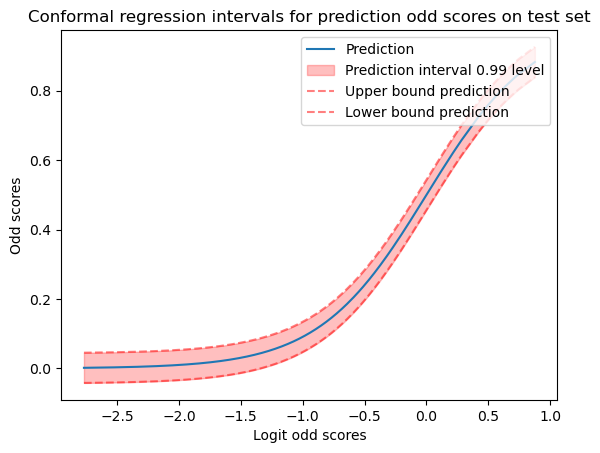

In [66]:
#wykres przedziałów ze skalą logitową
def logit_hist(x):
    return np.log10(x/(1-x))
plt.plot(logit_hist(x_odds),x_odds, label = 'Prediction')
plt.fill_between(logit_hist(x_odds), output[0,:], output[1,:], color='r', alpha=.25, label = f'Prediction interval {np.round(1-alpha,2)} level')
plt.plot(logit_hist(x_odds),output[0,:], label = 'Upper bound prediction', color = 'r', linestyle = '--', alpha = 0.5)
plt.plot(logit_hist(x_odds),output[1,:], label = 'Lower bound prediction', color = 'r', linestyle = '--', alpha = 0.5)
plt.legend(loc = 'upper right')
plt.xlabel('Logit odd scores')
plt.ylabel('Odd scores')
plt.title('Conformal regression intervals for prediction odd scores on test set')
plt.show()